# 教師データが少ない時の対応(補足)
数理モデルないし学習アルゴリズムを使う場合に時として教師データが少ないことがある。当たり前だが、こういった場合にモデルを作ると選択性バイアスが発生した時のように本来と異なる値を取ることがある。

そこで、ベイズ推定におけるMCMC法(マルコフ連鎖モンテカルロ法)を用いて精度を上げる手法がある。実際にMCMC法で線形回帰を行うと一般的な線形回帰とは異なる切片と係数になる事を確認する。

## ライブラリのインポート

In [1]:
from scipy.stats import mstats
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import emcee

## データの読み込み

In [2]:
df = pd.read_csv("wine.csv")
df.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
2,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
3,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
4,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


## 相関係数の算出
この中で相関が高いデータを用いて二次元のプロットをする。

In [3]:
df.corr()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
Wine,1.000000,-0.328222,0.437776,-0.049643,0.517859,-0.209179,-0.719163,-0.847498,0.489109,-0.499130,0.265668,-0.617369,-0.788230,-0.633717
Alcohol,-0.328222,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720
Malic.acid,0.437776,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011
Ash,-0.049643,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626
Acl,0.517859,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597
Mg,-0.209179,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351
Phenols,-0.719163,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115
Flavanoids,-0.847498,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193
Nonflavanoid.phenols,0.489109,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385
Proanth,-0.499130,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417


## 相関係数が高かったデータの全データの散布図

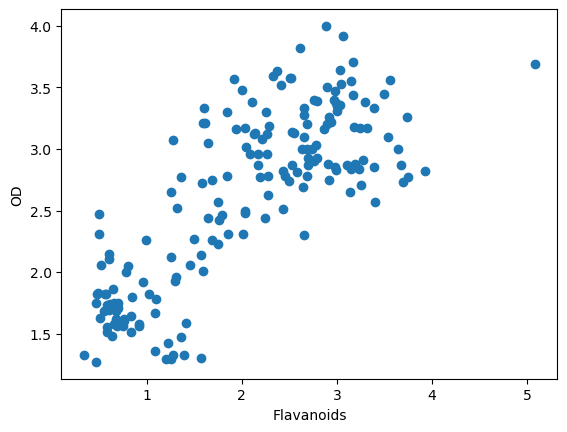

In [4]:
plt.scatter(df["Flavanoids"], df["OD"])
plt.xlabel("Flavanoids")
plt.ylabel("OD")
plt.show()

In [5]:
x = sm.add_constant(df["Flavanoids"])
y = df["OD"]

## 教師データと訓練データを分ける
ここではデータが不足する事を想定して教師データを10%とする。

In [6]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.9, random_state=0)
OLS = sm.OLS(y_train, x_train).fit()
OLS.summary()

C:\Users\decar\anaconda\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     OD   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     18.02
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           0.000705
Time:                        21:37:50   Log-Likelihood:                -11.353
No. Observations:                  17   AIC:                             26.71
Df Residuals:                      15   BIC:                             28.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5850      0.270      5.875      0.000       1.010       2.160
Flavanoids     0.5813      0.137      4.245      0.001       0.289       0.873
==============================================================================
Omnibus:                        4.195   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                1.854
Skew:                           0.480   Prob(JB):                        0.396
Kurtosis:                       1.698   Cond. No.                         5.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## テストデータに対して回帰を行う

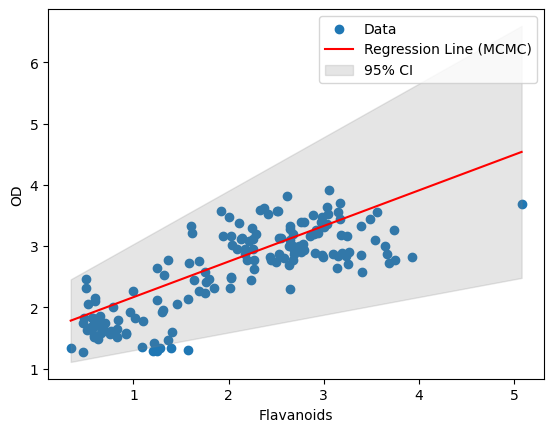

In [7]:
plt.scatter(x_test["Flavanoids"], y_test, label='Data')
x_plot = np.linspace(x["Flavanoids"].min(), x["Flavanoids"].max(), 100)
y_plot = OLS.params[0] + OLS.params[1] * x_plot
plt.plot(x_plot, y_plot, color='red', label='Regression Line (MCMC)')
plt.fill_between(x_plot,
                 OLS.conf_int(alpha=0.05).at["const", 0] + OLS.conf_int(alpha=0.05).at["Flavanoids", 0] * x_plot,
                 OLS.conf_int(alpha=0.05).at["const", 1] + OLS.conf_int(alpha=0.05).at["Flavanoids", 1] * x_plot,
                 color='gray',
                 alpha=0.2,
                 label='95% CI')
plt.xlabel('Flavanoids')
plt.ylabel('OD')
plt.legend()
plt.show()

In [8]:
y_pred = OLS.predict(x_test)
print(r2_score(y_test, y_pred))

0.5747980966253712


## MCMC法

In [9]:
def model(theta, x):
    return theta[0] + theta[1] * x

In [10]:
def ln_likelihood(theta, x, y):
    y_model = model(theta, x)
    residuals = y - y_model
    return -0.5 * np.sum(residuals**2)

In [11]:
def ln_prior(theta):
    return 0.0

In [12]:
def ln_posterior(theta, x, y):
    return ln_prior(theta) + ln_likelihood(theta, x, y)

In [13]:
ndim = 2  # パラメータ数
nwalkers = 100  # ウォーカーの数
initial_theta = np.random.rand(nwalkers, ndim)  # 初期パラメータ

In [14]:
x = x_train['Flavanoids']
y = y_train

### マルコフ連鎖モンテカルロ法の実行

In [15]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(x, y))
sampler.run_mcmc(initial_theta.reshape((nwalkers, ndim)), 1000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.74it/s]


State([[ 2.18998108  0.3823013 ]
 [ 1.15574748  0.66166559]
 [ 1.50876106  0.48232932]
 [ 0.6293196   0.85110131]
 [ 1.33305934  0.61939333]
 [ 1.54964947  0.63470825]
 [ 1.38700598  0.60115252]
 [ 2.05139951  0.25554786]
 [ 1.91798929  0.44967962]
 [ 1.23689713  0.71086719]
 [ 1.566862    0.73985436]
 [ 2.10872689  0.32596828]
 [ 2.62590188  0.01190976]
 [ 1.29929815  0.73210334]
 [ 0.80535033  0.86116035]
 [ 0.63397004  1.15193682]
 [ 1.29341623  0.88082919]
 [ 1.95864468  0.68078231]
 [ 1.04914208  0.70899674]
 [ 1.16737036  1.09376047]
 [ 1.25944206  0.64042055]
 [ 0.90202951  0.7941497 ]
 [ 2.37803688  0.34107773]
 [ 1.24635936  0.6582249 ]
 [ 1.03792881  0.72164918]
 [ 1.86235048  0.51769762]
 [ 1.7657051   0.51823604]
 [ 1.6712754   0.46812749]
 [ 1.29288435  0.65727532]
 [ 2.0637526   0.41968212]
 [ 1.73774601  0.66684885]
 [ 0.47888972  1.07275035]
 [ 2.25968957  0.31914402]
 [ 1.40877921  0.42930112]
 [ 0.50883471  1.29717035]
 [ 1.77405437  0.58284016]
 [ 1.88360655  0.48094

In [16]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
theta_mcmc = np.median(samples, axis=0)

### 95%CIを算出

In [17]:
ci_low, ci_high = mstats.mquantiles(samples, [0.025, 0.975], axis=0)

### 結果の確認
#### 回帰式

In [18]:
print("MCMC結果:")
print("切片:", theta_mcmc[0])
print("傾き:", theta_mcmc[1])

MCMC結果:
切片: 1.5868357104486628
傾き: 0.5803119282362434


#### 回帰式の95%CI

In [19]:
print("95%信頼区間（切片）:", ci_low[0], ci_high[0])
print("95%信頼区間（傾き）:", ci_low[1], ci_high[1])

95%信頼区間（切片）: 0.5381470992893288 2.640077236030712
95%信頼区間（傾き）: 0.050420886861770986 1.1149821069801118


### 結果のプロット

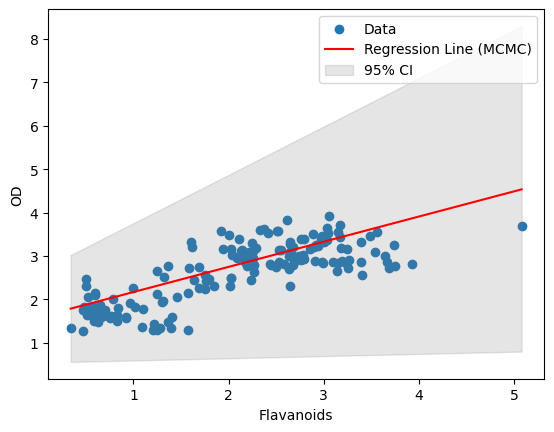

In [20]:
plt.scatter(x_test["Flavanoids"], y_test, label='Data')
x_plot = np.linspace(df["Flavanoids"].min(), df["Flavanoids"].max(), 100)
y_plot = theta_mcmc[0] + theta_mcmc[1] * x_plot
plt.plot(x_plot, y_plot, color='red', label='Regression Line (MCMC)')
plt.fill_between(x_plot, ci_low[0] + ci_low[1] * x_plot, 
                 ci_high[0] + ci_high[1] * x_plot, 
                 color='gray',
                 alpha=0.2,
                 label='95% CI')
plt.xlabel('Flavanoids')
plt.ylabel('OD')
plt.legend()
plt.show()

若干だがMCMC法を用いている回帰の方が点の集合の真ん中を通っている事が分かる。
### 事前分布と事後分布

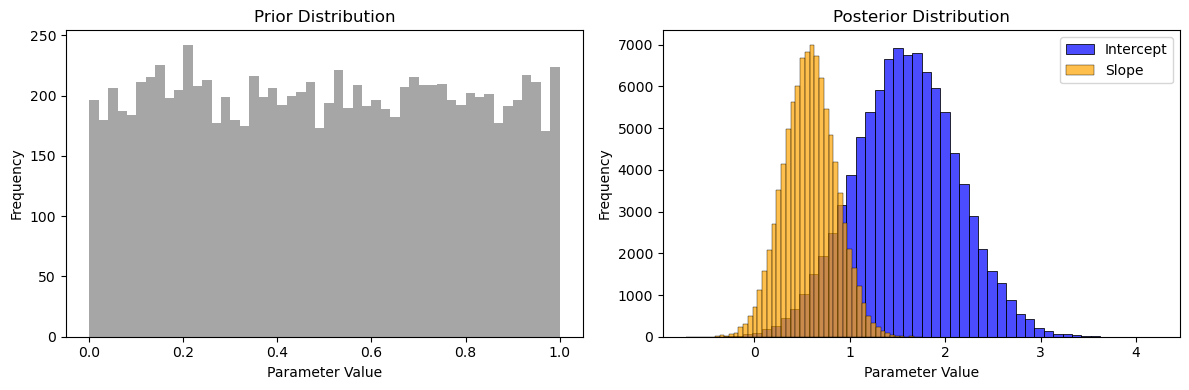

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Prior Distribution')
plt.hist(np.random.rand(10000), bins=50, color='gray', alpha=0.7)
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.title('Posterior Distribution')
sns.histplot(samples[:, 0], bins=50, color='blue', alpha=0.7, label='Intercept')
sns.histplot(samples[:, 1], bins=50, color='orange', alpha=0.7, label='Slope')
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### トレースプロットの描画

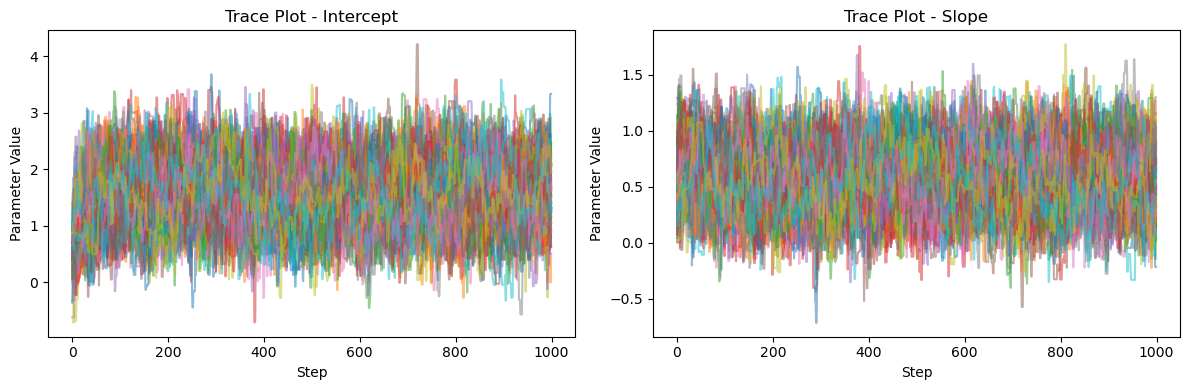

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('Trace Plot - Intercept')
for i in range(nwalkers):
    plt.plot(sampler.chain[i, :, 0], alpha=0.5)
plt.xlabel('Step')
plt.ylabel('Parameter Value')
plt.subplot(1, 2, 2)
plt.title('Trace Plot - Slope')
for i in range(nwalkers):
    plt.plot(sampler.chain[i, :, 1], alpha=0.5)
plt.xlabel('Step')
plt.ylabel('Parameter Value')
plt.tight_layout()
plt.show()

In [23]:
y_pred = theta_mcmc[0] + theta_mcmc[1] * x_test["Flavanoids"].values
print(r2_score(y_test, y_pred))

0.5749940964077975


もちろんデータによってR2がMCMCの方が下回る事もあるが、MCMC法を用いることで少ないサンプル数が少なく不確実性があってもこのように精度を上げることができる。